Names: Fabio Lenherr & Kaj Habegger

## Import required libraries

In [3]:
! pip install tensorflow
! pip install matplotlib

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.1


In [2]:
# Check whether GPU is available for ML or not
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load data

In [3]:
train_dir = 'datasets/dataset_training/'
test_dir = 'datasets/dataset_testing/'
batch_size = 32
img_height = 256
img_width = 256

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width) # Some preprocessing happening here, resizing the images
)


test_ds = train_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width) # Some preprocessing happening here, resizing the images
)

Found 16277 files belonging to 11 classes.
Found 9979 files belonging to 11 classes.


## Data information and visualization

In [129]:
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(class_names)

['bug', 'electric', 'fire', 'fly', 'grass', 'ground', 'normal', 'poison', 'psychic', 'rock', 'water']


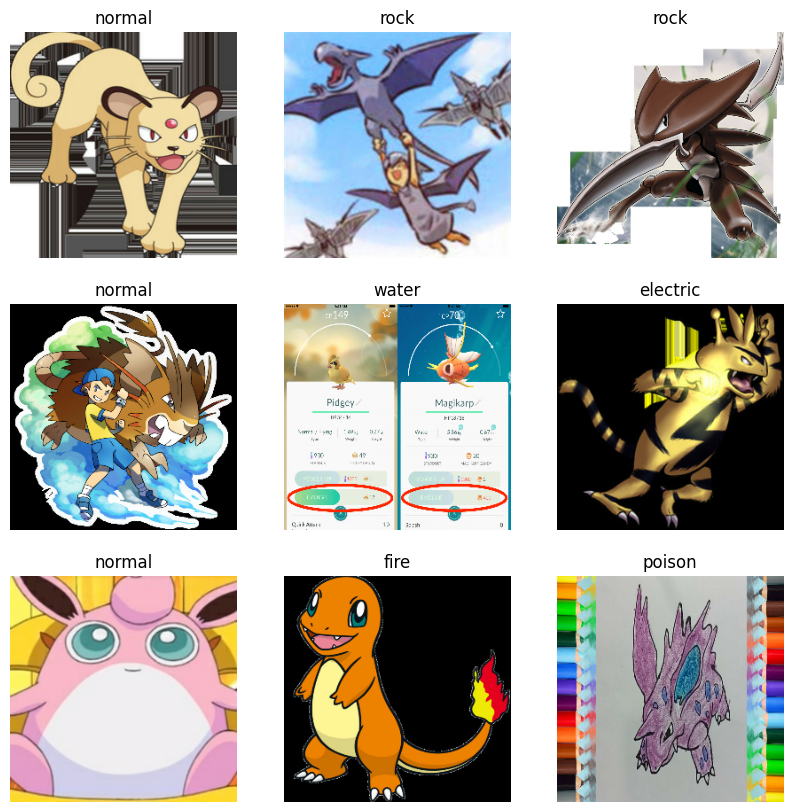

In [130]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [131]:
# Shape of each Batch
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

In [224]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.
# This will ensure the dataset does not become a bottleneck while training your model.
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

# Dataset.prefetch overlaps data preprocessing and model execution while training

## Define model

In [158]:
model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Dense(11)
])

## Compile model

In [159]:
model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

## Train model

In [160]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3
)

Epoch 1/3
312/312 [==============================] - 19s 59ms/step - loss: 1.9569 - acc: 0.3906 - val_loss: 1.3450 - val_acc: 0.5844
Epoch 2/3
312/312 [==============================] - 6s 20ms/step - loss: 1.2013 - acc: 0.6193 - val_loss: 0.6421 - val_acc: 0.8305
Epoch 3/3
312/312 [==============================] - 6s 20ms/step - loss: 0.6285 - acc: 0.8149 - val_loss: 0.3088 - val_acc: 0.9190


In [161]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 123008)          

In [162]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

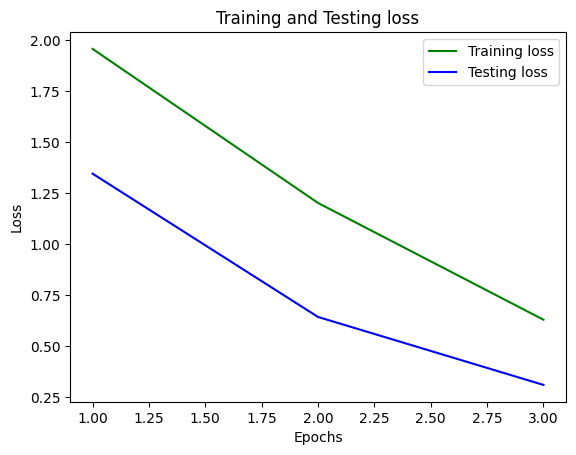

In [163]:
# Plotting training and validation loss
epochs = range(1,4)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

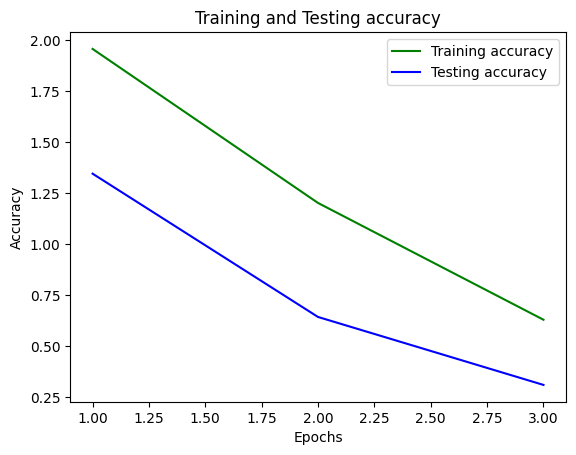

In [164]:
# Plotting training and validation accuracy
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Testing accuracy')
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Underfitted Model

In [ ]:
underfitted_model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    #layers.Conv2D(16, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Dense(11)
])

## Overfitted Model

In [4]:
overfitted_model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu')
])

In [5]:
overfitted_model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [6]:
overfitted_history = overfitted_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=4
)

Epoch 1/4
312/312 [==============================] - 43s 124ms/step - loss: 3.1396 - acc: 0.3259 - val_loss: 2.6086 - val_acc: 0.4250
Epoch 2/4
312/312 [==============================] - 37s 117ms/step - loss: 2.5381 - acc: 0.4558 - val_loss: 2.1813 - val_acc: 0.5509
Epoch 3/4
312/312 [==============================] - 37s 117ms/step - loss: 2.1547 - acc: 0.5704 - val_loss: 1.7955 - val_acc: 0.6665
Epoch 4/4
312/312 [==============================] - 37s 117ms/step - loss: 1.7238 - acc: 0.6820 - val_loss: 1.5053 - val_acc: 0.7356


In [8]:
overfitted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 256)       2

In [9]:
acc = overfitted_history.history['acc']
val_acc = overfitted_history.history['val_acc']
loss = overfitted_history.history['loss']
val_loss = overfitted_history.history['val_loss']

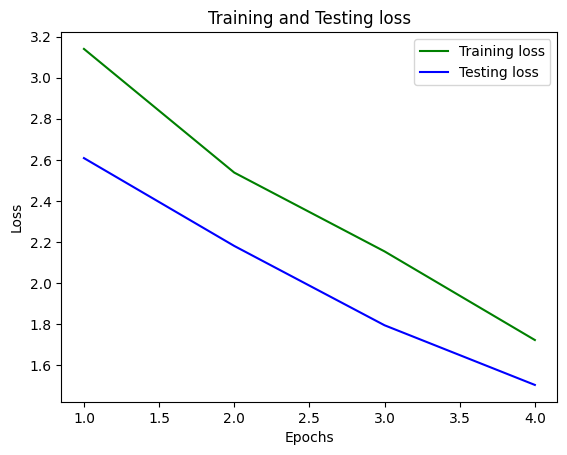

In [10]:
# Plotting training and validation loss
epochs = range(1,5)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

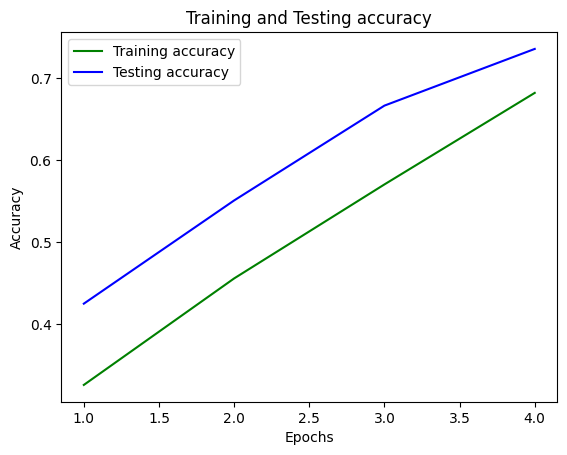

In [11]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Testing accuracy')
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Optimized Model

## Prediction

In [207]:
probability_model = tf.keras.Sequential([overfitted_model, 
                                         tf.keras.layers.Softmax()])

In [218]:
predictions = probability_model.predict(test_ds)

312/312 [==============================] - 9s 29ms/step


In [219]:
predictions[0]

array([0.07862699, 0.07862711, 0.07862699, 0.07862699, 0.07862699,
       0.07862699, 0.21372995, 0.078627  , 0.07862699, 0.07862699,
       0.07862699], dtype=float32)

In [220]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(11))
  plt.yticks([])
  thisplot = plt.bar(range(11), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


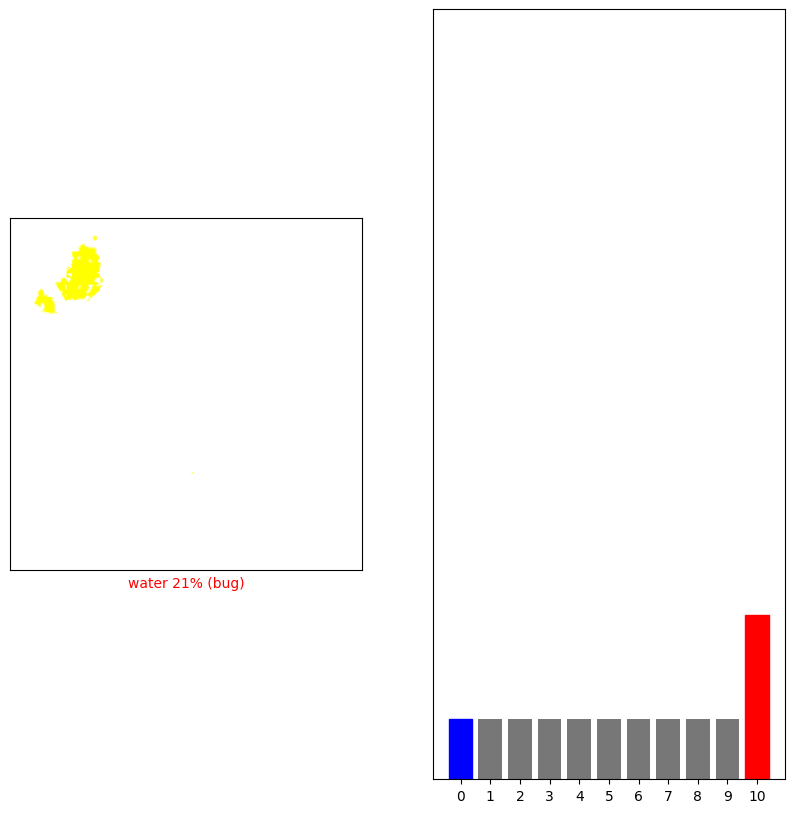

In [222]:
i = 16
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
#for images, labels in test_ds.take(1):
iterator = iter(test_ds)
image, labels = next(iterator)
plot_image(i, predictions[i], labels, image)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels)
plt.show()

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

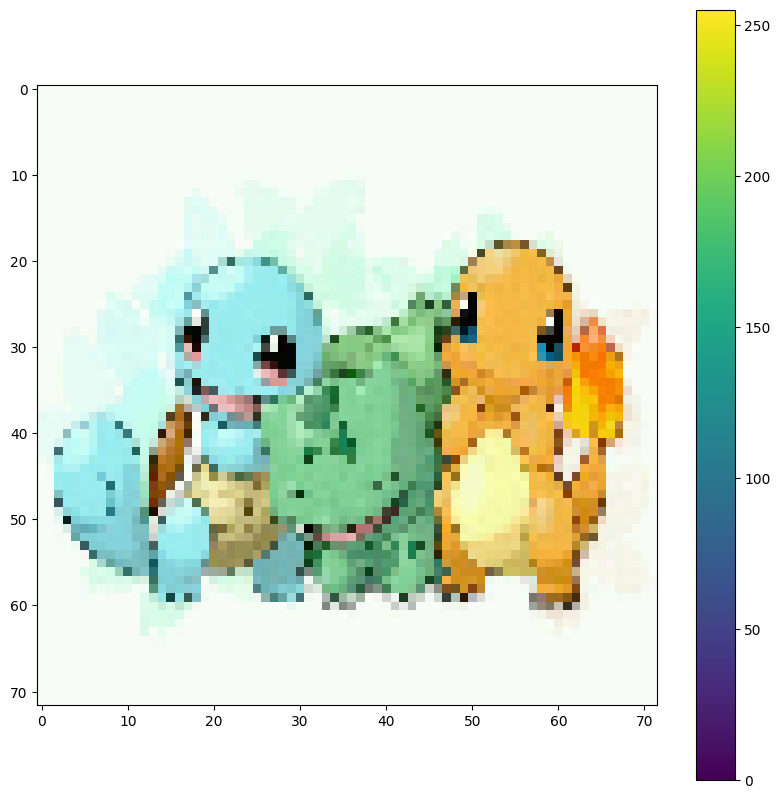

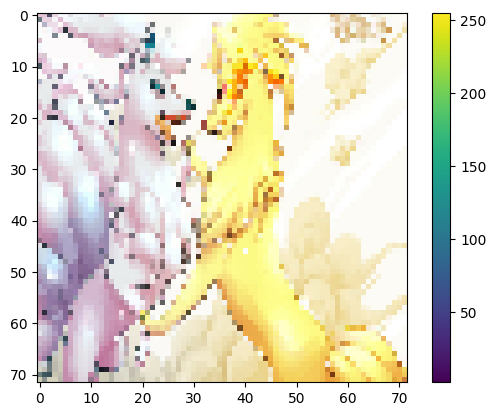

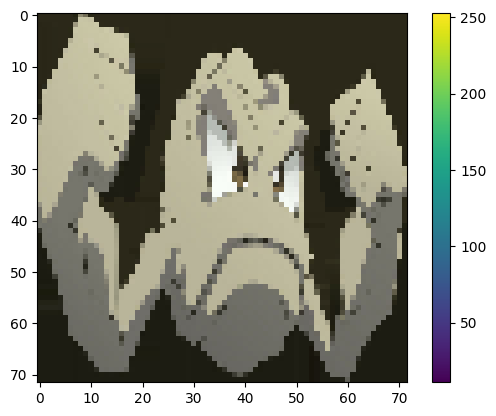

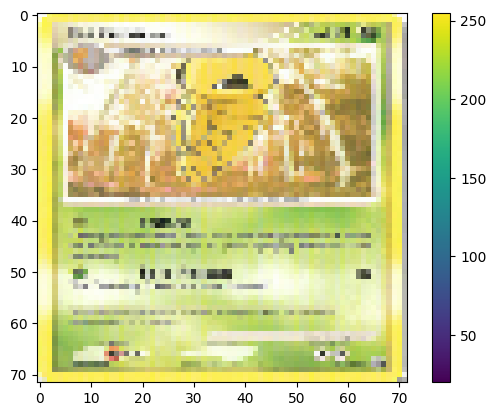

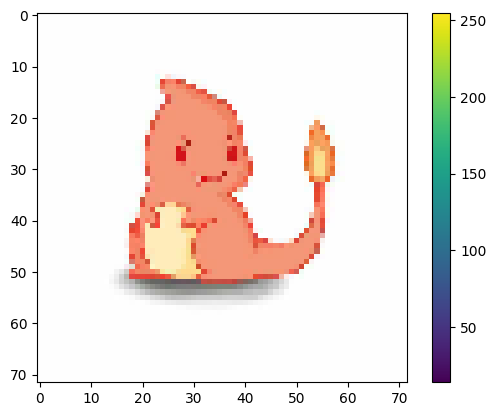

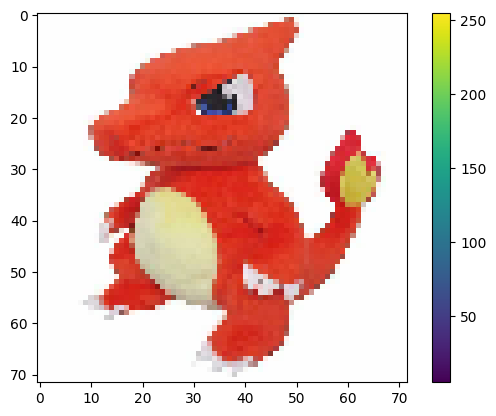

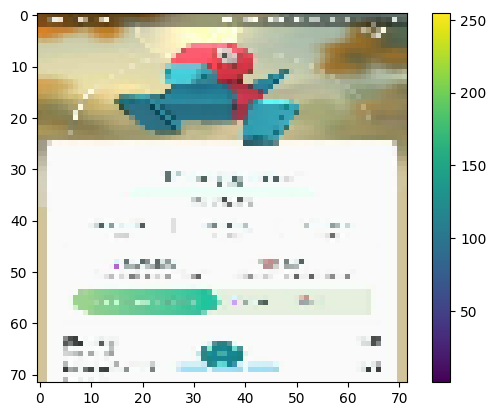

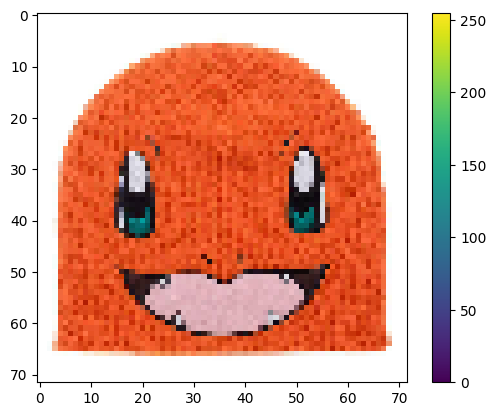

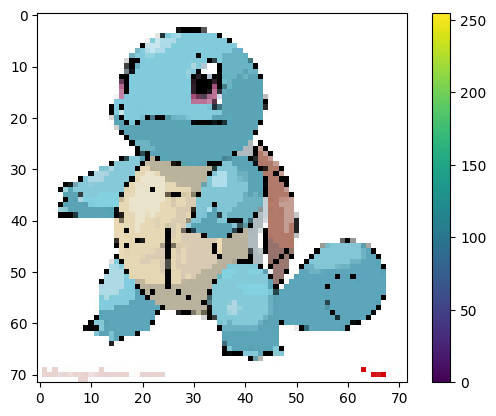

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.colorbar()
        plt.grid(False)
        plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

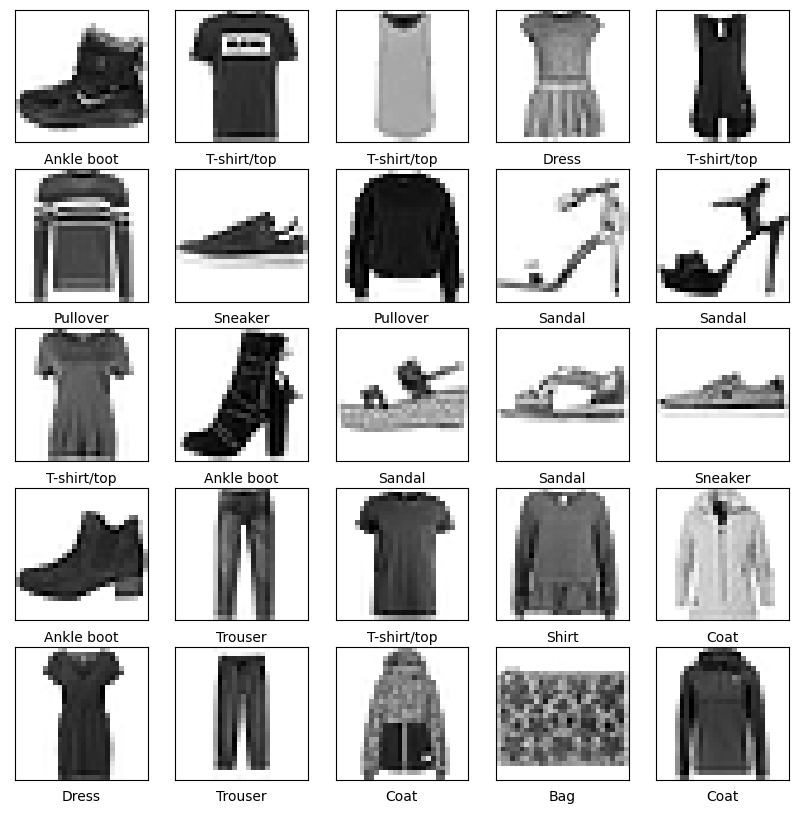

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4960 - accuracy: 0.8246
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3721 - accuracy: 0.8663
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3355 - accuracy: 0.8779
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3085 - accuracy: 0.8874
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2936 - accuracy: 0.8918
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2758 - accuracy: 0.8978
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2652 - accuracy: 0.9016
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2536 - accuracy: 0.9049
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2445 - accuracy: 0.9086
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.237

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3446 - accuracy: 0.8803 - 597ms/epoch - 2ms/step

Test accuracy: 0.880299985408783


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

313/313 [==============================] - 0s 1ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

array([5.6023999e-09, 7.3096351e-10, 7.0384121e-09, 2.0413071e-15,
       8.2098889e-10, 8.8997092e-04, 2.6417115e-09, 8.5922601e-03,
       1.4499091e-09, 9.9051780e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [21]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [22]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

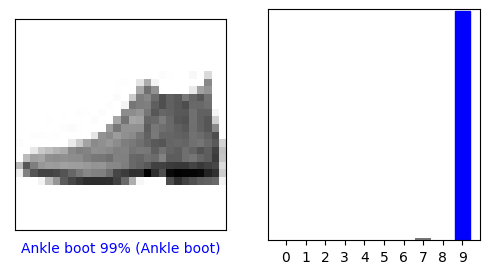

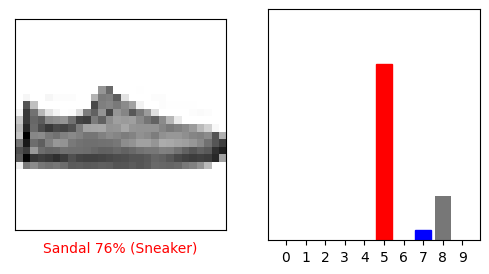

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

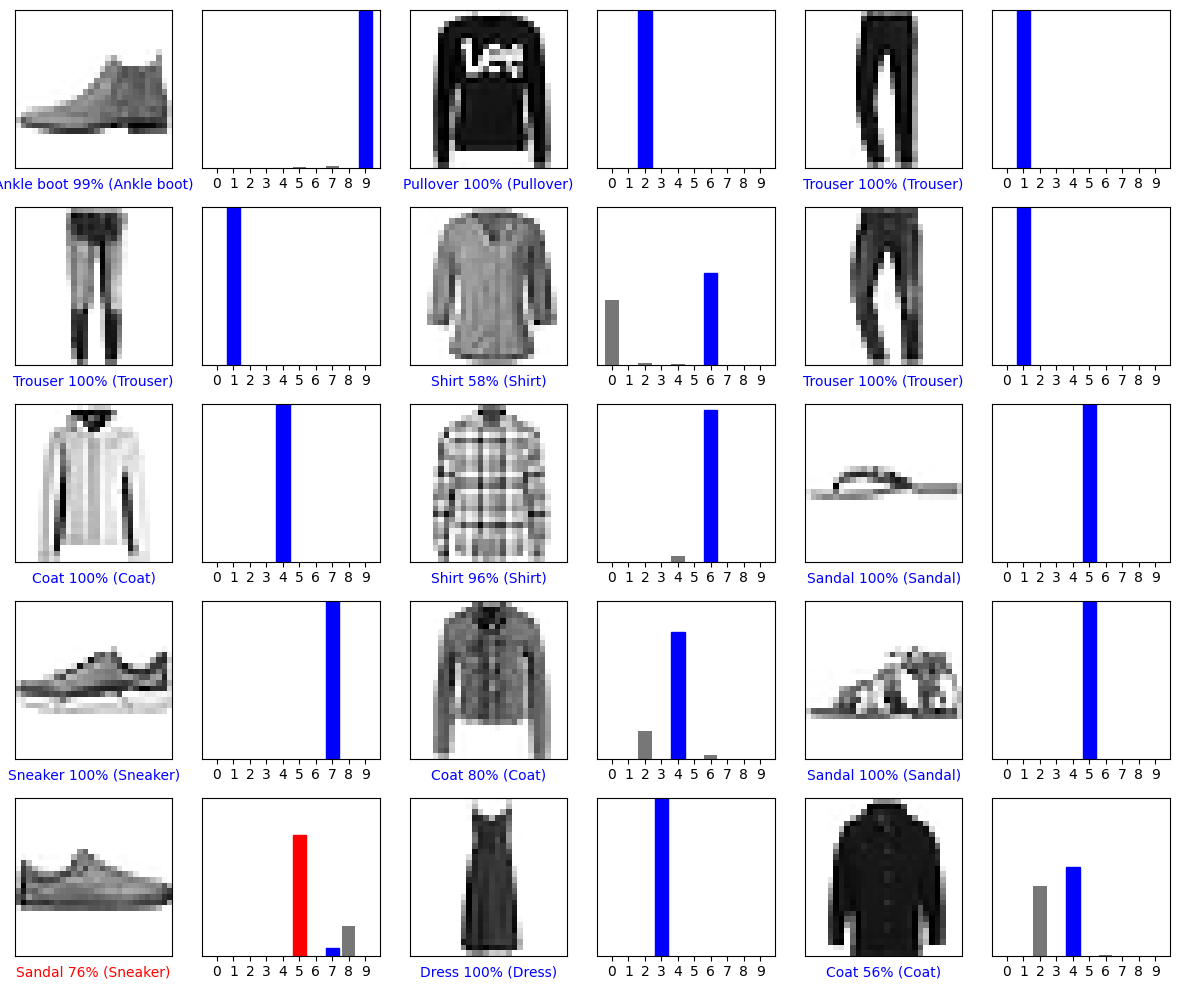

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [27]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [28]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [29]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 22ms/step
[[9.8218006e-06 1.6241313e-12 9.9978024e-01 2.5675090e-10 1.4467262e-04
  5.7958114e-14 6.5363645e-05 5.1339265e-20 3.2502893e-13 2.1984588e-13]]


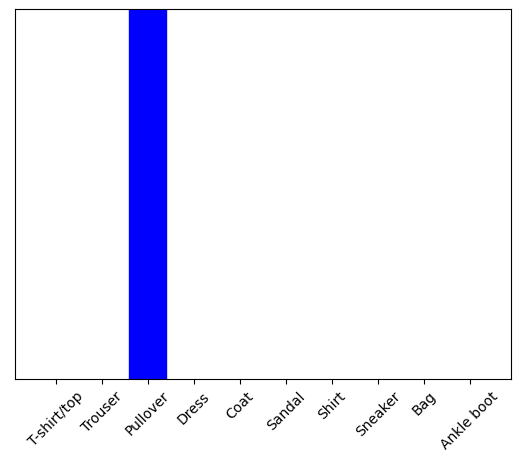

In [30]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [31]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.